In [9]:
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score, multilabel_confusion_matrix, precision_recall_fscore_support, precision_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC

In [10]:
x = np.load('../Part1.npy')
Y_t = np.load('../train.npy/y_train.npy')
#X_train = (x-np.min(x))/(np.max(x)-np.min(x))
xt = np.load('../Part2.npy')
Y_test = np.load('../test.npy/Y_Test.npy')
#X_test = (xt-np.min(xt))/(np.max(xt)-np.min(xt))
x_add = np.load('../Part3.npy')
y_add = np.load('../additional.npy/Y_additional.npy')
#x_add = (x_add-np.min(x_add))/(np.max(x_add)-np.min(x_add))
Y_train = np.concatenate((Y_t, Y_test, y_add))
X_train = np.concatenate((x, xt, x_add))
#X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [11]:
X_test = np.load('X_single.npy')
Y_test = np.load('Y_single.npy')
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [12]:
class OvrMLP(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes, activation, solver, alpha, batch_size, learning_rate, learning_rate_init, 
                 max_iter, shuffle, warm_start):
        super(OvrMLP, self).__init__()
        self.activation = activation
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.max_iter = max_iter
        self.model = MLPClassifier(activation = activation, hidden_layer_sizes = hidden_layer_sizes ,solver = 'adam',
                                   alpha = alpha, batch_size = 200, learning_rate_init= learning_rate_init, max_iter = max_iter)
        self.ovr = OneVsRestClassifier(self.model)
        self.solver = solver
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.shuffle = shuffle
        self.warm_start = warm_start
    def fit(self, X_train, Y_train):
        #self.chain = ClassifierChain(self.model, order="random", random_state=1)
        return self.ovr.fit(X_train, Y_train)
    
    def score(self, X_test, Y_test):
        Y_pred_chain = self.ovr.predict(X_test)
        chain_jaccard_score = jaccard_score(Y_test, Y_pred_chain, average="samples")
        return chain_jaccard_score
        

In [13]:
search_space = {
    'hidden_layer_sizes': [(100), (200), (50)],
    'activation': ['identity', 'logistic', 'relu', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': (1e-5, 1e-2, 'log-uniform'),
    'batch_size': [50, 100, 200, 500],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': (0.0001, 0.1, 'log-uniform'),
    'max_iter': (50, 200),
    'shuffle': [True, False],
    'warm_start':[True, False],
    
}

test = OvrMLP((100), activation = 'tanh', solver = 'adam', alpha= 0.001,learning_rate='constant', 
                learning_rate_init= 0.01, batch_size=200, max_iter = 200, shuffle = True, warm_start = True)
opt = BayesSearchCV(test, search_space, n_iter=50, cv=7, n_jobs=-1)
opt.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

BayesSearchCV(cv=7,
              estimator=OvrMLP(activation='tanh', alpha=0.001, batch_size=200,
                               hidden_layer_sizes=100, learning_rate='constant',
                               learning_rate_init=0.01, max_iter=200,
                               shuffle=True, solver='adam', warm_start=True),
              n_jobs=-1,
              search_spaces={'activation': ['identity', 'logistic', 'relu',
                                            'tanh'],
                             'alpha': (1e-05, 0.01, 'log-uniform'),
                             'batch_size': [50, 100, 200, 500],
                             'hidden_layer_sizes': [100, 200, 50],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': (0.0001, 0.1, 'log-uniform'),
                             'max_iter': (50, 200), 'shuffle': [True, False],
                             'solver': ['lbfgs', 'sgd', 'adam'],
                             'warm_start': [True, False]})

In [14]:
print("Best parameters found: ", opt.best_params_)
print("Best score: ", opt.best_score_)

Best parameters found:  OrderedDict([('activation', 'relu'), ('alpha', 0.0009409856915620283), ('batch_size', 100), ('hidden_layer_sizes', 50), ('learning_rate', 'invscaling'), ('learning_rate_init', 0.00012577230419867763), ('max_iter', 59), ('shuffle', False), ('solver', 'adam'), ('warm_start', True)])
Best score:  0.1963644257774322


In [15]:
import warnings
warnings.filterwarnings("ignore")
mlp = MLPClassifier(activation = 'logistic',hidden_layer_sizes = [100] ,solver = 'lbfgs',alpha = 0.0053, batch_size = 200, 
                    learning_rate='constant', learning_rate_init=0.0041, max_iter = 193, warm_start=True, shuffle=True)
ovr = OneVsRestClassifier(mlp)
ovr.fit(X_train, Y_train)

OneVsRestClassifier(estimator=MLPClassifier(activation='logistic', alpha=0.0053,
                                            batch_size=200,
                                            hidden_layer_sizes=[100],
                                            learning_rate_init=0.0041,
                                            max_iter=193, solver='lbfgs',
                                            warm_start=True))

In [16]:
pred = ovr.predict(X_test)
m = multilabel_confusion_matrix(Y_test, pred)
print(m)

[[[6134  183]
  [ 379    9]]

 [[6114   86]
  [ 499    6]]

 [[6020  234]
  [ 432   19]]

 [[4948 1120]
  [ 460  177]]

 [[3825 2120]
  [ 468  292]]

 [[5177  846]
  [ 547  135]]

 [[4332 1652]
  [ 458  263]]

 [[5636  443]
  [ 566   60]]

 [[5926  202]
  [ 556   21]]

 [[5710  415]
  [ 537   43]]

 [[3517 2410]
  [ 434  344]]]


In [17]:
m[0]

array([[6134,  183],
       [ 379,    9]])

In [18]:
precision = np.array([x[1,1]/(x[1,1]+x[0,1]) for x in m])
recall = np.array([x[1,1]/(x[1,1]+x[1,0]) for x in m])
f1 = 2*precision*recall/(precision+recall)
print(precision)

[0.046875   0.06521739 0.07509881 0.13646877 0.12106136 0.13761468
 0.13733681 0.11928429 0.0941704  0.09388646 0.12490922]


In [19]:
recall

array([0.02319588, 0.01188119, 0.0421286 , 0.27786499, 0.38421053,
       0.19794721, 0.36477115, 0.09584665, 0.03639515, 0.07413793,
       0.44215938])

In [20]:
f1

array([0.03103448, 0.0201005 , 0.05397727, 0.18304033, 0.18411097,
       0.16235719, 0.19954476, 0.10628875, 0.0525    , 0.08285164,
       0.19479049])

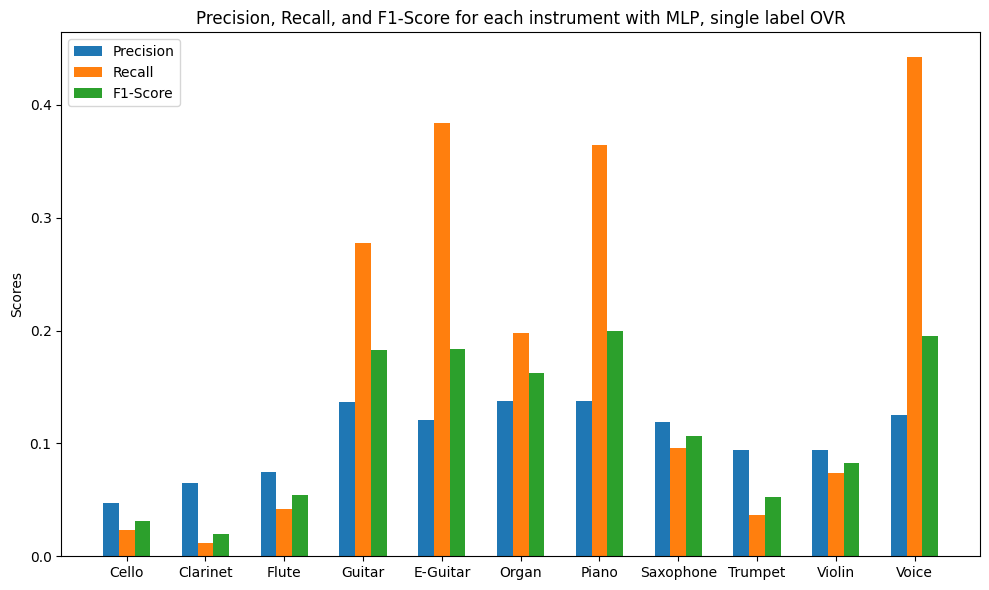

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
x_ax = ["Cello","Clarinet", "Flute", "Guitar", "E-Guitar", "Organ", "Piano", "Saxophone", "Trumpet", "Violin", "Voice"]
x = np.arange(len(precision))  # the label locations
width = 0.2  # the width of the bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for each instrument with MLP, single label OVR')
ax.set_xticks(x)
ax.set_xticklabels([i for i in x_ax])
ax.legend()
fig.tight_layout()
plt.savefig('ScoresMLPsingleOVR.png')
plt.show()